**Zadanie 1**  
Uruchom przykład Incremental learning z punktu 2.1 dobierając parametry tak, aby ilość danych do przeliczenia była większa niż sumaryczna ilość pamięci RAM workerów. Obserwuj daszboard i w razie niepowodzenia dostosuj wielkość i ilość chunków tak, aby obliczenia się wykonały na tych samych parametrach workerów. Zobacz jak wygląda struktura pamięci na workerach, czy nie dochodzi do zrzucania pamięci na dysk (zapewne będzie on wąskim gardłem, więc w menedżerze będzie widać jego mocne obciążenie). Zastanów się czy można to jakoś zoptymalizować przy dostępnych workerach i wykonaj kilka eksperymentów szukając większej wydajności i krótszego czasu wykonania całego zadania.

In [1]:

from datetime import datetime

from dask.distributed import Client

# pamiętaj o zamykaniu klientów lub używaniu już wcześniej stworzonego

client = Client(n_workers=2, threads_per_worker=2, memory_limit="4GB")
# client = Client(n_workers=3, threads_per_worker=2, memory_limit="3GB") # all workers died
# client = Client(n_workers=4, threads_per_worker=2, memory_limit="4GB")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:65011,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:65022,Total threads: 2
Dashboard: http://127.0.0.1:65023/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:65014,


In [2]:
# przykład z użyciem incremental learning z dokumentacji dask
# z lekką modyfikacją

import dask.array as da
from dask_ml.datasets import make_classification
from dask_ml.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from dask_ml.wrappers import Incremental

# dostosuj wielkość zbioru oraz ilość/wielkość chunka
# wielkość chunka niedobrana prawidłowo do pamięci na workerze może
# skutecznie zakończyć przeliczanie całego grafu
# przy parametrach poniżej potrzeba około 38GB pamięci RAM, ale przy dobrze
# dobranych chunkach obliczymy to na dużo mniejszej ilości zasobów
# wykonanie poniższego kodu na mojej maszynie z zadanymi parametrami klastra lokalnego
# zajęło kilkanaście minut
# n, d = 10_000_000, 500 # plus /64 - start val

start = datetime.now()
# for n_workers=4, threads_per_worker=2, memory_limit="4GB"
# n, d, ch = 1_000_000, 500, 64 # czas: 0:00:12.241696
# n, d, ch = 1_000_000, 500, 128 # czas:  0:00:14.728505
# n, d, ch = 10_000_000, 500, 64 # czas: blue screen
# n, d, ch = 10_000_000, 500, 128 #  czas: 0:02:19.435074
# n, d, ch = 10_000_000, 500, 256 #  czas: 0:02:07.365329

# for n_workers=2, threads_per_worker=2, memory_limit="4GB"
# n, d, ch = 1_000_000, 500, 64 # czas: 0:00:13.414435
# n, d, ch = 1_000_000, 500, 128 # czas: 0:00:17.287476
# n, d, ch = 10_000_000, 500, 64 # czas: 0:02:57.566592
# n, d, ch = 10_000_000, 500, 128 #  czas: 0:01:46.317152
n, d, ch = 10_000_000, 500, 256  #  czas: 0:01:42.713503

X, y = make_classification(n_samples=n, n_features=d,
                           chunks=n // ch, flip_y=0.2)
display(X)

X_train, X_test, y_train, y_test = train_test_split(X, y)
display(X_train)

# jeżeli dysponujemy wystarczająco dużą ilością pamięci RAM rozproszoną po workerach
# to możemy przechować dane właśnie tam w celu przyspieszenia części obliczeń
# X_train, X_test, y_train, y_test = dask.persist(X_train, X_test, y_train, y_test)


classes = da.unique(y_train).compute()
# classes

est = SGDClassifier(loss='log_loss', penalty='l2', tol=1e-3)
inc = Incremental(est, scoring='accuracy')

inc.fit(X_train, y_train, classes=classes)

D:\Users\weron\Documents\__My documents\__Studia\_Magister\s2\AD2\.venvL3ClassTest\Lib\site-packages\dask\base.py:1101: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


dask.array<normal, shape=(10000000, 500), dtype=float64, chunksize=(39062, 500), chunktype=numpy.ndarray>

dask.array<concatenate, shape=(8999795, 500), dtype=float64, chunksize=(35155, 500), chunktype=numpy.ndarray>

Incremental(estimator=SGDClassifier(loss='log_loss'), scoring='accuracy')

In [3]:
inc.score(X_test, y_test)

np.float64(0.6199739053494033)

In [4]:
print(f'end : {datetime.now() - start}')

end : 0:01:43.635439


**Zadanie 2**  
Dokonaj serializacji modelu z zadania 1 na dysk i następnie go wczytaj ponownie tak, aby można było uruchomić na nim predykcję dla tablic X_test oraz y_test (dla użycia miar klasyfikacji) i wyświetl macierz klasyfikacji (confusion matrix).

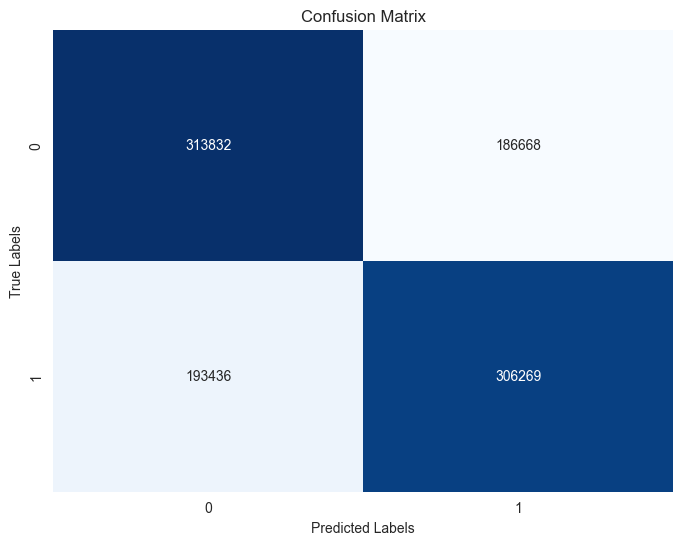

              precision    recall  f1-score   support

           0       0.62      0.63      0.62    500500
           1       0.62      0.61      0.62    499705

    accuracy                           0.62   1000205
   macro avg       0.62      0.62      0.62   1000205
weighted avg       0.62      0.62      0.62   1000205


In [5]:
import joblib
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Serialize the model to disk
joblib.dump(inc, 'model_task1.joblib')  # Save the model to a file

# Load the model from disk
loaded_model = joblib.load('model_task1.joblib')  # Load the model

# Make predictions with the loaded model
y_pred = loaded_model.predict(X_test)  # Generate predictions on X_test

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Optionally, display classification report for additional metrics
print(classification_report(y_test, y_pred))

**Zadanie 3**  
Korzystając z danych stworzonych w zadaniu 1 uruchom poszukiwanie optymalnych parametrów modelu tak jak zostało to zaprezentowane w przykładzie 5. 
Ta metoda powinna sama wybierać modele obiecujące i trenować je na większej liczbie danych porzucając jednocześnie modele, które nie rokują.
Sprawdź jak wyglądają najlepsze wyliczone parametry vs. te użyte w zadaniu 1 i ewentualnie dopasuj próbkę danych jeżeli jej inicjalna wielkość nie pozwala na wykonanie zadania (zwróć uwagę na ilość i wielkość chunków w przykładzie 3 oraz 5, w tym drugim jest ich znacznie więcej, co przyspiesza poszukiwanie optymalnych parametrów).

In [6]:
from dask_ml.model_selection import IncrementalSearchCV
from sklearn.linear_model import SGDClassifier
import numpy as np

model = SGDClassifier(tol=1e-3, penalty='elasticnet', random_state=0)

params = {'alpha': np.logspace(-2, 1, num=1000),
          'l1_ratio': np.linspace(0, 1, num=1000),
          'average': [True, False]}

search = IncrementalSearchCV(model, params, random_state=0,
                             n_initial_parameters=1000,
                             patience=20, max_iter=100)

#  Fit the model using Dask data arrays with chunked data
# Assuming X and y from Task 1 are already in Dask format
search.fit(X, y, classes=[0, 1])

# Step 4: Retrieve and display best parameters
best_model = search.best_estimator_
print("Best Parameters:", search.best_params_)
print("Best Cross-Validation Score:", search.best_score_)

D:\Users\weron\Documents\__My documents\__Studia\_Magister\s2\AD2\.venvL3ClassTest\Lib\site-packages\dask_ml\model_selection\_incremental.py:1039: FutureWarning: decay_rate has been deprecated since Dask-ML v1.4.0.

    * Use InverseDecaySearchCV to use `decay_rate`
    * Specify decay_rate=None


  warn(


Best Parameters: {'l1_ratio': np.float64(0.5725725725725725), 'average': False, 'alpha': np.float64(0.04706224849841281)}
Best Cross-Validation Score: 0.6490632950427877
